In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-behavior-data-from-multi-category-store/2019-Nov.csv
/kaggle/input/ecommerce-behavior-data-from-multi-category-store/2019-Oct.csv


In [2]:
# Will a Customer Buy Again?
## Objective
# Predict whether a customer will make a repeat purchase based on their behavior during their first few visits/orders.

## Tools
# - Python
# - Model: Logistic Regression, Random Forest

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [4]:
df = pd.read_csv('/kaggle/input/ecommerce-behavior-data-from-multi-category-store/2019-Nov.csv' , parse_dates=['event_time'], nrows=1000000 ) 
##df = df.sample(n=min(1_000_000, len(df)), random_state=42).reset_index(drop=True)

In [5]:
df = df[df['event_type'].isin(['view', 'cart', 'purchase'])]

# Feature Engineering
df.sort_values(by=['user_id', 'event_time'], inplace=True)
df['is_purchase'] = (df['event_type'] == 'purchase').astype(int)

In [6]:
user_features = df.groupby('user_id').agg({
    'event_time': ['min', 'max', 'count'],
    'event_type': lambda x: (x == 'purchase').sum(),
    'price': 'mean',
    'product_id': pd.Series.nunique,
    'category_code': pd.Series.nunique,
    'user_session': pd.Series.nunique
})

print(user_features)

# Flatten column names
user_features.columns = ['first_event', 'last_event', 'total_events',
                         'purchase_count', 'avg_price_viewed',
                         'unique_products', 'unique_categories',
                         'session_count']

# Derived features
user_features['active_days'] = (user_features['last_event'] - user_features['first_event']).dt.days
user_features['made_repeat_purchase'] = (user_features['purchase_count'] > 1).astype(int)

# Clean up
user_features.reset_index(inplace=True)
X = user_features[['total_events', 'avg_price_viewed', 'unique_products',
                   'unique_categories', 'session_count', 'active_days']]
y = user_features['made_repeat_purchase']

# Filling missing values
X.fillna(0, inplace=True)

                         event_time                                  \
                                min                       max count   
user_id                                                               
274969076 2019-11-01 06:18:48+00:00 2019-11-01 06:52:33+00:00     3   
275256741 2019-11-01 02:23:03+00:00 2019-11-01 02:23:03+00:00     1   
295643776 2019-11-01 03:12:38+00:00 2019-11-01 03:15:53+00:00     8   
296465302 2019-11-01 04:10:21+00:00 2019-11-01 05:11:24+00:00    25   
319315209 2019-11-01 13:54:30+00:00 2019-11-01 13:56:34+00:00     3   
...                             ...                       ...   ...   
566505649 2019-11-01 15:31:17+00:00 2019-11-01 15:31:17+00:00     1   
566505680 2019-11-01 15:31:26+00:00 2019-11-01 15:31:26+00:00     1   
566505735 2019-11-01 15:31:37+00:00 2019-11-01 15:31:37+00:00     1   
566505770 2019-11-01 15:32:06+00:00 2019-11-01 15:32:06+00:00     1   
566505856 2019-11-01 15:32:07+00:00 2019-11-01 15:32:07+00:00     1   

     

/tmp/ipykernel_13/385896014.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


Classification Report:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     50285
           1       0.24      0.10      0.14       817

    accuracy                           0.98     51102
   macro avg       0.61      0.55      0.56     51102
weighted avg       0.97      0.98      0.98     51102



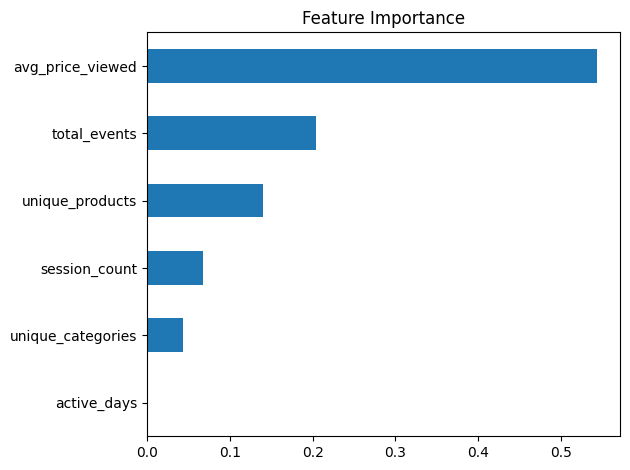

In [7]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Feature importance
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', title='Feature Importance')
plt.tight_layout()
plt.show()